## **Summarization**

### **Chuẩn bị tập dữ liệu song ngữ cho mô hình tóm tắt**

- **Nguồn dữ liệu**: Sử dụng **Multilingual Amazon Reviews Corpus** gồm đánh giá sản phẩm bằng 6 ngôn ngữ. Tác giả chọn tiếng Anh và tiếng Tây Ban Nha.

- **Mục tiêu**: Dùng **review_title** làm tóm tắt (summary) cho **review_body** để huấn luyện mô hình tóm tắt song ngữ.

- **Dữ liệu tải về**:
  - Mỗi ngôn ngữ có 200,000 mẫu huấn luyện, 5,000 mẫu validation, 5,000 mẫu test.


In [2]:
from datasets import load_dataset

# can switch to use it if dataset is disable
# https://www.kaggle.com/datasets/mexwell/amazon-reviews-multi

spanish_dataset = load_dataset("amazon_reviews_multi", "es")
english_dataset = load_dataset("amazon_reviews_multi", "en")
english_dataset

README.md:   0%|          | 0.00/47.0 [00:00<?, ?B/s]

amazon_reviews_multi.py:   0%|          | 0.00/6.17k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/24.6M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/613k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/619k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/200000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5000 [00:00<?, ? examples/s]

0000.parquet:   0%|          | 0.00/28.3M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/713k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/711k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/200000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 200000
    })
    validation: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 5000
    })
})


- **Lọc theo domain**:
  - Chỉ giữ lại các đánh giá thuộc **sách** (book & digital_ebook_purchase).
  - Sử dụng `Dataset.filter()` để lọc theo cột `product_category`.

In [ ]:
def filter_books(example):
    return (
        example["product_category"] == "book"
        or example["product_category"] == "digital_ebook_purchase"
    )
spanish_books = spanish_dataset.filter(filter_books)
english_books = english_dataset.filter(filter_books)


- **Kết hợp dữ liệu song ngữ**:
  - Dùng `concatenate_datasets()` để trộn hai ngôn ngữ cho từng split (train/val/test).
  - Shuffle lại để tránh overfitting vào một ngôn ngữ cụ thể.

- **Tiền xử lý bổ sung**:
  - Loại bỏ các mẫu có tiêu đề (title) quá ngắn (`<= 2 từ`) vì có thể gây sai lệch cho mô hình tóm tắt.

In [ ]:
from datasets import concatenate_datasets, DatasetDict

books_dataset = DatasetDict()

for split in english_books.keys():
    books_dataset[split] = concatenate_datasets(
        [english_books[split], spanish_books[split]]
    )
    books_dataset[split] = books_dataset[split].shuffle(seed=42)

books_dataset = books_dataset.filter(lambda x: len(x["review_title"].split()) > 2)

### **Models for text summarization**

- Tóm tắt văn bản có thể xem như một dạng "dịch" từ văn bản dài sang ngắn hơn, giữ lại nội dung chính.
- Vì vậy, hầu hết các mô hình Transformer cho tóm tắt sử dụng kiến trúc **encoder-decoder** giống như dịch máy.

---

### **Các mô hình Transformer phổ biến cho tóm tắt**

| Mô hình      | Mô tả                                                                 | Đa ngôn ngữ |
|--------------|----------------------------------------------------------------------|-------------|
| **GPT-2**     | Mô hình sinh văn bản đơn hướng; có thể dùng tóm tắt bằng thủ thuật `"TL;DR"` | ❌          |
| **PEGASUS**   | Tiền huấn luyện bằng việc dự đoán câu bị che trong văn bản dài – rất gần với bài toán tóm tắt | ❌          |
| **T5**        | Kiến trúc thống nhất dạng text-to-text, dùng prefix như `"summarize: ..."` để xác định task | ❌          |
| **mT5**       | Phiên bản đa ngôn ngữ của T5, huấn luyện trên **mC4 corpus** (101 ngôn ngữ) | ✅          |
| **BART**      | Encoder-decoder, tiền huấn luyện kết hợp giữa BERT và GPT-2 (reconstruct corrupted text) | ❌          |
| **mBART-50**  | Phiên bản đa ngôn ngữ của BART, hỗ trợ 50 ngôn ngữ                  | ✅          |

---

### **Chọn mô hình: mT5**

- **mT5** là phiên bản đa ngôn ngữ của T5, rất phù hợp cho bài toán tóm tắt song ngữ.
- Không dùng prefix như `"summarize:"` như T5, nhưng vẫn giữ được tính linh hoạt trong khung text-to-text.
- Phù hợp để áp dụng trong các bài toán xử lý ngôn ngữ ít tài nguyên.
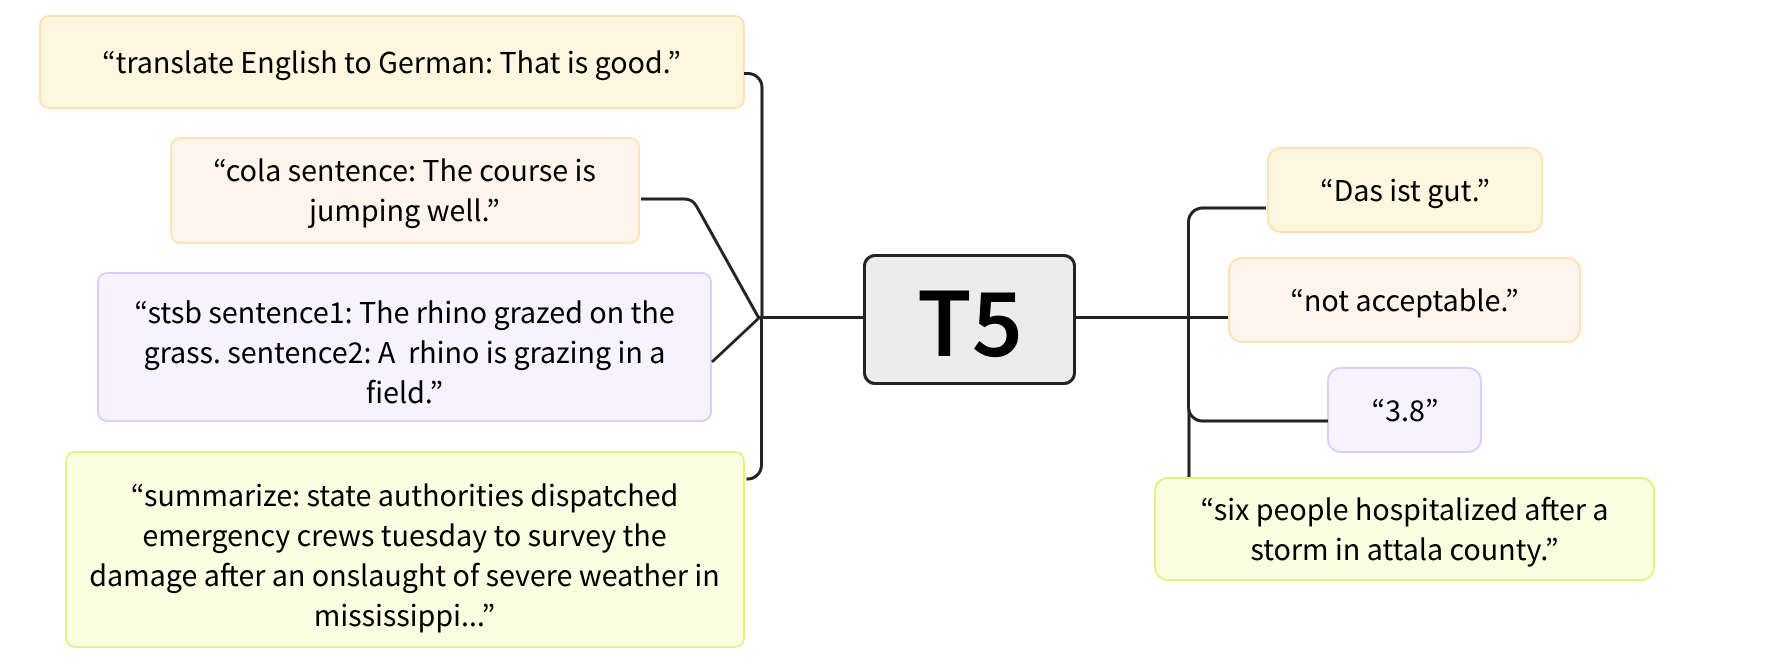
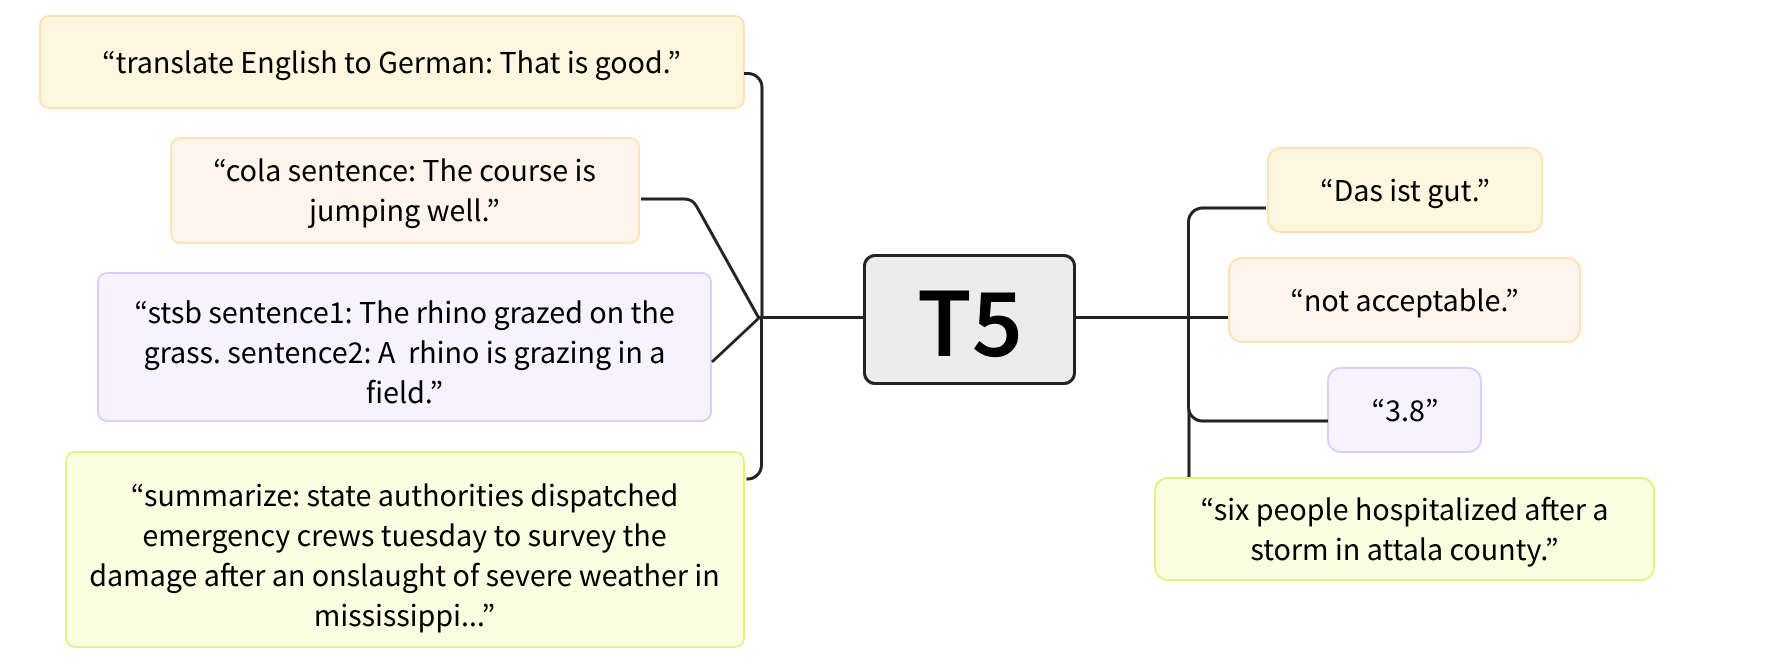

### **Preprocessing the data**
#### **1. Tải tokenizer cho mô hình mT5**

- Dùng checkpoint: `google/mt5-small`
- Lý do: nhẹ, dễ huấn luyện thử nghiệm trên tập dữ liệu nhỏ để debug nhanh.
---

In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "google/mt5-small"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

inputs = tokenizer("I loved reading the Hunger Games!")
inputs


#### **2. Kiểm tra tokenizer**

- Tokenizer sử dụng SentencePiece → cho thấy dấu `▁` trong tokens.
- Hữu ích cho dữ liệu đa ngôn ngữ (không cần khoảng trắng giữa từ).
---


In [ ]:
tokenizer.convert_ids_to_tokens(inputs.input_ids)


#### **3. Tiền xử lý dữ liệu**

- Cần **truncation** cả review lẫn title để tránh vượt quá chiều dài tối đa của mô hình.
- Dùng `text_target` để token hóa song song input và label.

---

#### **4. Áp dụng tiền xử lý cho toàn bộ dataset**

In [3]:
max_input_length = 512
max_target_length = 30


def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["review_body"],
        max_length=max_input_length,
        truncation=True,
    )
    labels = tokenizer(
        examples["review_title"], max_length=max_target_length, truncation=True
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = books_dataset.map(preprocess_function, batched=True)

NameError: name 'books_dataset' is not defined

### **Metrics for text summarization**

#### **Vì sao đánh giá khó?**

- Tóm tắt là bài toán sinh ngôn ngữ → nhiều câu trả lời đúng.
- Không thể dùng exact match (so khớp chính xác) như các bài toán phân loại.
- Giải pháp: dùng các **thước đo dựa trên mức độ trùng khớp** như **ROUGE**.

---

#### **Giới thiệu ROUGE**

- **ROUGE** = *Recall-Oriented Understudy for Gisting Evaluation*.
- So sánh giữa tóm tắt sinh ra (generated) và tóm tắt gốc (reference).
- Tính các chỉ số: **precision**, **recall**, **F1-score**.

#### Công thức

**Recall**: mức độ mà tóm tắt sinh ra bao phủ tóm tắt gốc.  
$$\text{Recall} = \frac{\text{Số từ trùng nhau}}{\text{Tổng số từ trong tóm tắt gốc}}$$

**Precision**: mức độ mà từ trong tóm tắt sinh ra là "đúng".  
$$\text{Precision} = \frac{\text{Số từ trùng nhau}}{\text{Tổng số từ trong tóm tắt sinh ra}}$$

**F1**: trung bình điều hòa của precision và recall.

---

#### **Cài đặt ROUGE trong Hugging Face**

```bash
pip install rouge_score
```

```python
import evaluate
rouge_score = evaluate.load("rouge")
```
---

## 🧠 **Các biến thể của ROUGE**

| Tên biến thể | Mô tả |
|--------------|-------|
| **rouge1**   | Trùng khớp đơn vị từ (unigrams) |
| **rouge2**   | Trùng khớp cụm hai từ liên tiếp (bigrams) |
| **rougeL**   | Độ dài chuỗi từ liên tiếp trùng nhau dài nhất |
| **rougeLsum** | Giống rougeL nhưng áp dụng trên toàn bộ tóm tắt |

---

In [ ]:
import evaluate

rouge_score = evaluate.load("rouge")

scores = rouge_score.compute(
    predictions=[generated_summary], references=[reference_summary]
)
scores

### **Fine-tuning mT5 with Trainer API**

In [ ]:
from transformers import AutoModelForSeq2SeqLM
from huggingface_hub import notebook_login

notebook_login()

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [ ]:
from transformers import Seq2SeqTrainingArguments

batch_size = 8
num_train_epochs = 8
# Show the training loss with every epoch
logging_steps = len(tokenized_datasets["train"]) // batch_size
model_name = model_checkpoint.split("/")[-1]

args = Seq2SeqTrainingArguments(
    output_dir=f"{model_name}-finetuned-amazon-en-es",
    evaluation_strategy="epoch",
    learning_rate=5.6e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=num_train_epochs,
    predict_with_generate=True,
    logging_steps=logging_steps,
    push_to_hub=True,
)

In [ ]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Decode generated summaries into text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    # Decode reference summaries into text
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # ROUGE expects a newline after each sentence
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    # Compute ROUGE scores
    result = rouge_score.compute(
        predictions=decoded_preds, references=decoded_labels, use_stemmer=True
    )
    # Extract the median scores
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    return {k: round(v, 4) for k, v in result.items()}

In [4]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

tokenized_datasets = tokenized_datasets.remove_columns(
    books_dataset["train"].column_names
)

features = [tokenized_datasets["train"][i] for i in range(2)]
data_collator(features)

2025-04-17 14:25:36.493733: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744899936.749331      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744899936.830129      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


NameError: name 'tokenizer' is not defined

In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.evaluate()
trainer.push_to_hub(commit_message="Training complete", tags="summarization")